### DWT-MRA(1D)를 input으로 넣고 1D를 output으로 출력하는 모델 -> MRA level을 feature로 봄
#### Contaminated, Clean Scale을 다르게 함. (각자 scaling)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pywt

import sys
sys.path.append('../../../tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
from DataPlot import Data_Load_Plot, Result_Plot
from Scaling import time_inv_scaling

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


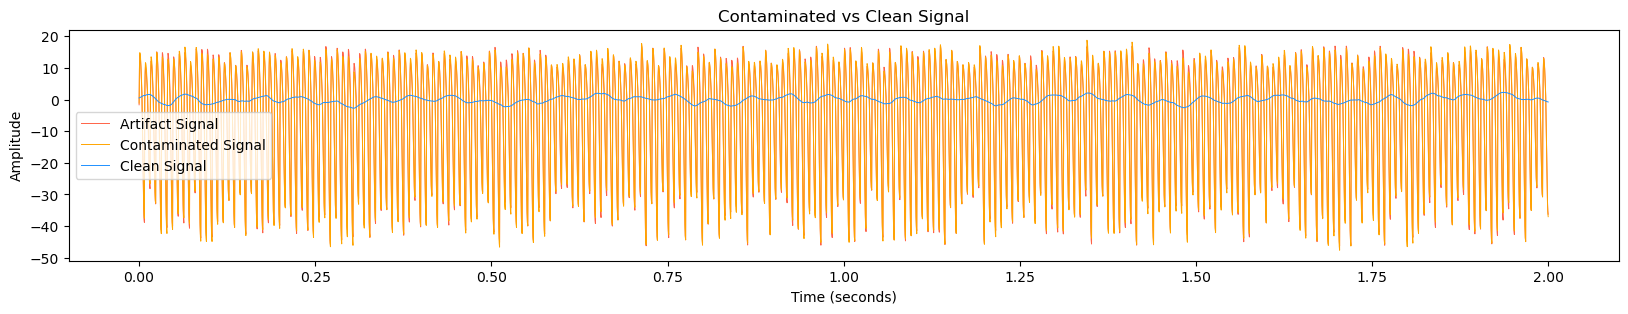

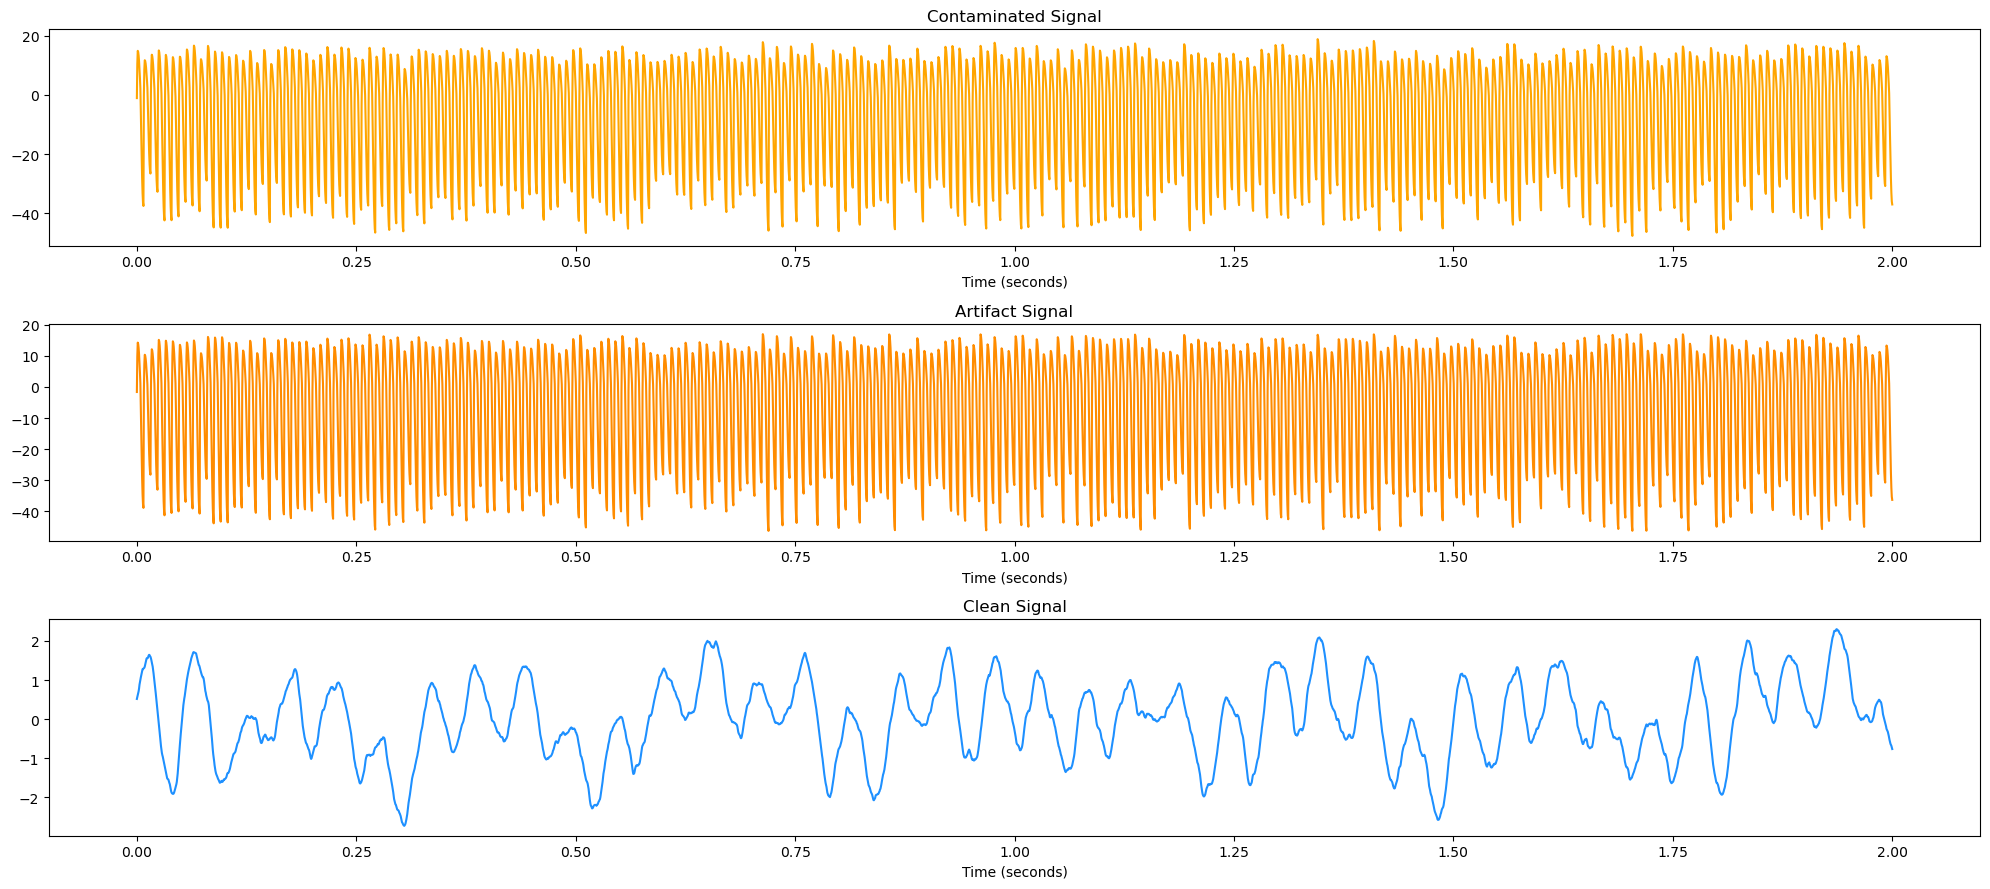

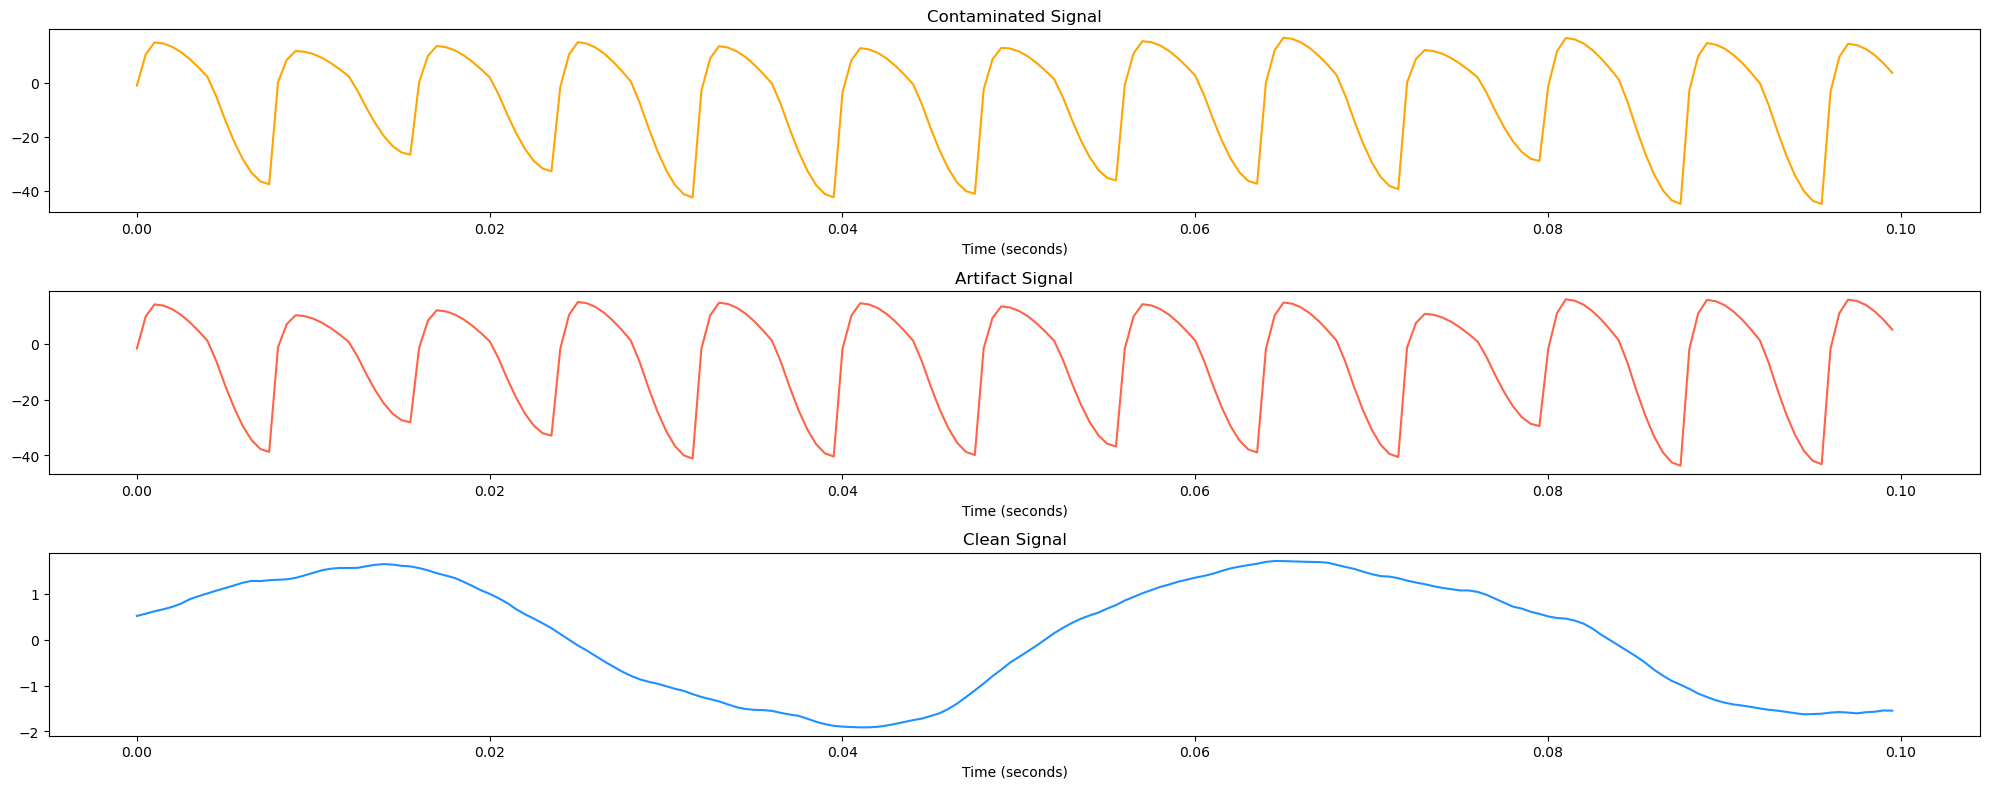

In [2]:
# 데이터 load & plot
datapath='../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

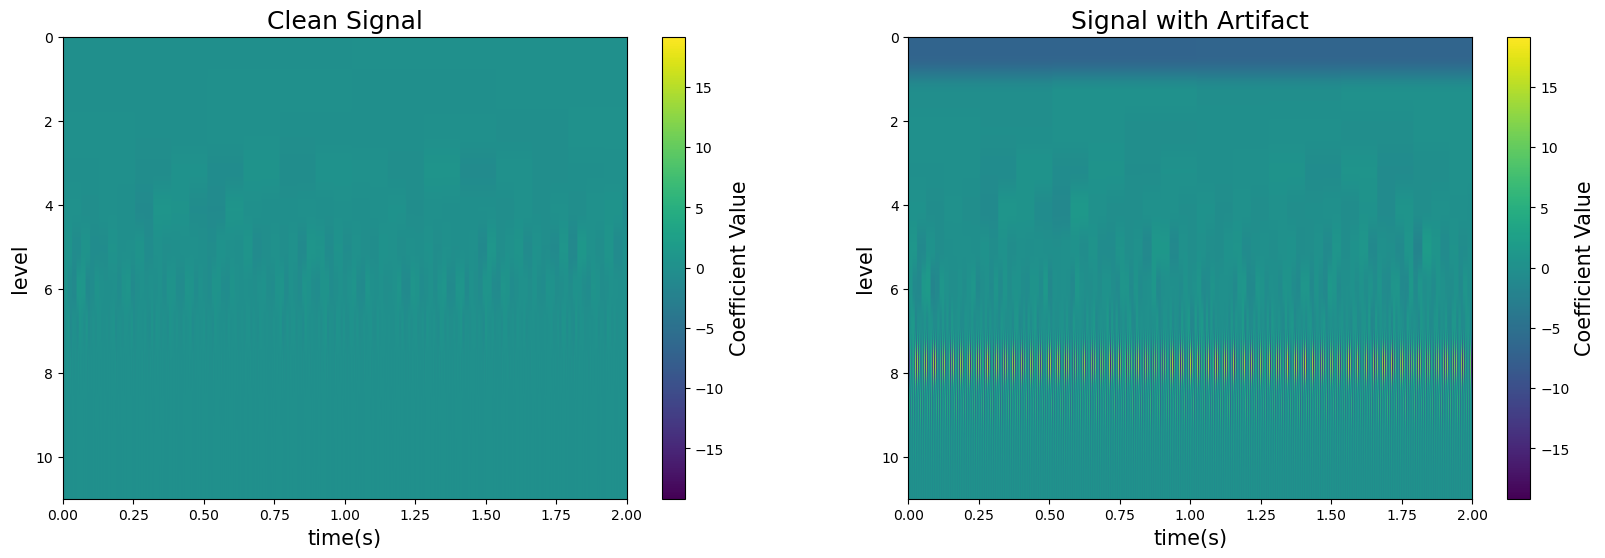

In [3]:
# DWT 수행 (MRA)
wavelet = 'db1'
mra_sig = pywt.mra(Clean_data[0], wavelet, transform='dwt')
mra_art = pywt.mra(Contaminated_data[0], wavelet, transform='dwt')

mra_sig = np.array(mra_sig)
mra_art = np.array(mra_art)

vmin, vmax = min(mra_sig.min(), mra_art.min()), max(mra_sig.max(), mra_art.max())

t = np.linspace(0, 2, num=4000)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.imshow(mra_sig, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean Signal', fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(mra_art, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Signal with Artifact', fontsize=18)

plt.show()

In [4]:
X_wt = []
y_wt = []

wavelet = 'db1'

for x, y in zip(Contaminated_data, Clean_data):
    mra_x = pywt.mra(x, wavelet, transform='dwt')
    mra_y = pywt.mra(y, wavelet, transform='dwt')
    X_wt.append(mra_x)
    y_wt.append(mra_y)

X_wt = np.array(X_wt)
y_wt = np.array(y_wt)

print("X_wt:", X_wt.shape)
print("y_wt:", y_wt.shape)

X_wt: (1000, 12, 4000)
y_wt: (1000, 12, 4000)


In [5]:
# MRA 결과 scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = []
y = [] 

scaler_x.fit(X_wt[0].flatten().reshape(-1, 1))
scaler_y.fit(y_wt[0].flatten().reshape(-1, 1))

for xx, yy in zip(X_wt, y_wt):
    flat_x = xx.flatten().reshape(-1, 1)
    flat_y = yy.flatten().reshape(-1, 1)
    scaled_flat_x = scaler_x.transform(flat_x)
    scaled_flat_y = scaler_y.transform(flat_y) # X, y 각자 scaling
    X.append(scaled_flat_x.reshape(xx.shape))
    y.append(scaled_flat_y.reshape(yy.shape))

X = np.array(X)
y = np.array(y)

print("X:", X.shape)
print("y:", y.shape)

X: (1000, 12, 4000)
y: (1000, 12, 4000)


In [6]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# # 차원 추가 (CNN은 두번째 차원 추가)
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]) # Batch x 1 x height x width
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

# print("<Unsqueezed>")
# print("-----------------------------")
# print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x 1 x T, y : B x T
# print("-----------------------------")
# print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
# print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 12, 4000)
y_train shape: (800, 12, 4000)
-----------------------------
X_test shape: (200, 12, 4000)
y_test shape: (200, 12, 4000)
-----------------------------


In [7]:
class CNN_MRA_1D(nn.Module):
    def __init__(self, in_channels=12, out_channels=12):
        super(CNN_MRA_1D, self).__init__()
        
        # Encoding path
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool1d(2, 2)
        
        # Decoding path
        self.upconv4 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = nn.Conv1d(64, out_channels, kernel_size=1)

        self.gelu = nn.GELU()
        
    def forward(self, x):
        # Encoding
        x1 = self.gelu(self.conv1(x))
        x2 = self.pool(self.gelu(self.conv2(x1)))
        x3 = self.pool(self.gelu(self.conv3(x2)))
        x4 = self.pool(self.gelu(self.conv4(x3)))

        # Decoding
        x4_up = self.upconv4(x4)
        x3_up = self.upconv3(x4_up)
        x2_up = self.upconv2(x3_up)
        x_out = self.upconv1(x2_up)
        
        return x_out

In [10]:
num_samples = 4000
height = 12
width = 2000

model = CNN_MRA_1D().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

CNN_MRA_1D(
  (conv1): Conv1d(12, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv4): ConvTranspose1d(512, 256, kernel_size=(2,), stride=(2,))
  (upconv3): ConvTranspose1d(256, 128, kernel_size=(2,), stride=(2,))
  (upconv2): ConvTranspose1d(128, 64, kernel_size=(2,), stride=(2,))
  (upconv1): Conv1d(64, 12, kernel_size=(1,), stride=(1,))
  (gelu): GELU(approximate='none')
)


In [11]:
# 모델 학습
num_epochs = 1000

loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_list.append(epoch_loss)
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

Epoch [1/1000], Loss: 0.9353558707237244
Epoch [2/1000], Loss: 0.7625446295738221
Epoch [3/1000], Loss: 0.6735456538200378
Epoch [4/1000], Loss: 0.6315834331512451
Epoch [5/1000], Loss: 0.626745970249176
Epoch [6/1000], Loss: 0.6225848436355591
Epoch [7/1000], Loss: 0.6192905139923096
Epoch [8/1000], Loss: 0.6143368411064148
Epoch [9/1000], Loss: 0.5736390471458435
Epoch [10/1000], Loss: 0.5295527923107147
Epoch [11/1000], Loss: 0.5229891884326935
Epoch [12/1000], Loss: 0.4592005741596222
Epoch [13/1000], Loss: 0.43802218079566957
Epoch [14/1000], Loss: 0.4270940625667572
Epoch [15/1000], Loss: 0.40353720664978027
Epoch [16/1000], Loss: 0.3822183346748352
Epoch [17/1000], Loss: 0.3716320765018463
Epoch [18/1000], Loss: 0.37250383377075197
Epoch [19/1000], Loss: 0.36714760184288026
Epoch [20/1000], Loss: 0.3612778151035309
Epoch [21/1000], Loss: 0.3594846165180206
Epoch [22/1000], Loss: 0.3581864058971405
Epoch [23/1000], Loss: 0.35205878496170045
Epoch [24/1000], Loss: 0.35412232041358

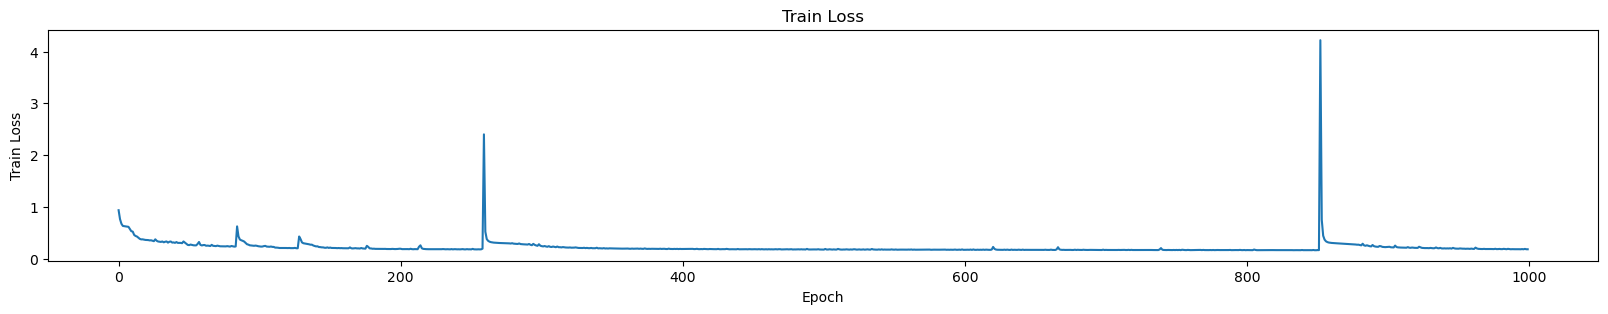

Minimal Train Loss: 0.16220371723175048 [849]

Test Loss: 0.1808


In [22]:
# train loss plot
plt.figure(figsize=(20, 3))
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title("Train Loss")
plt.show()

min_index, min_value = 0, 1
for idx, val in enumerate(loss_list):
    if val < min_value:
        min_index = idx
        min_value = val
print("Minimal Train Loss:", min_value, f"[{min_index}]\n")

# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Mean Absolute Error: 0.2464410960674286
Mean Squared Error: 0.15560251474380493


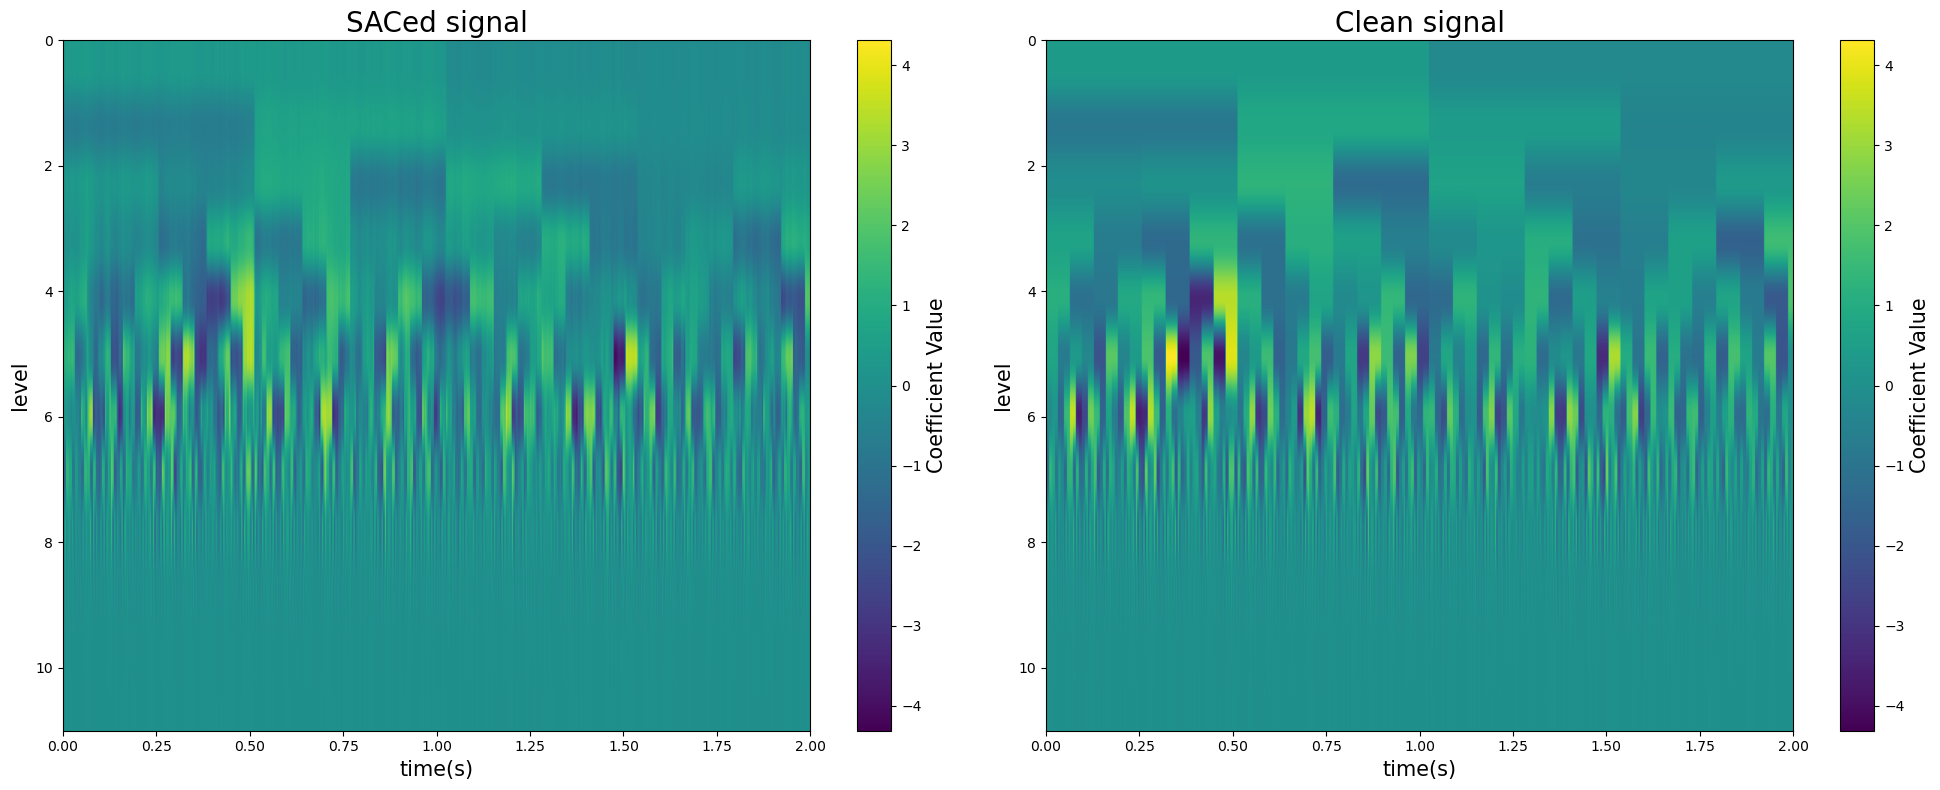

In [16]:
# MRA Plot
SACed_ex = SACed[0].detach().cpu()
Clean_ex = Clean[0].detach().cpu()

vmin, vmax = min(SACed_ex.min(), Clean_ex.min()), max(SACed_ex.max(), Clean_ex.max())

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(SACed_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('SACed signal', fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(Clean_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean signal', fontsize=20)

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_ex, SACed_ex)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_ex, SACed_ex)}")

(200, 4000)
<Time Domain Error>
Mean Absolute Error: 0.03357570845180789
Mean Squared Error: 0.001973741801367944


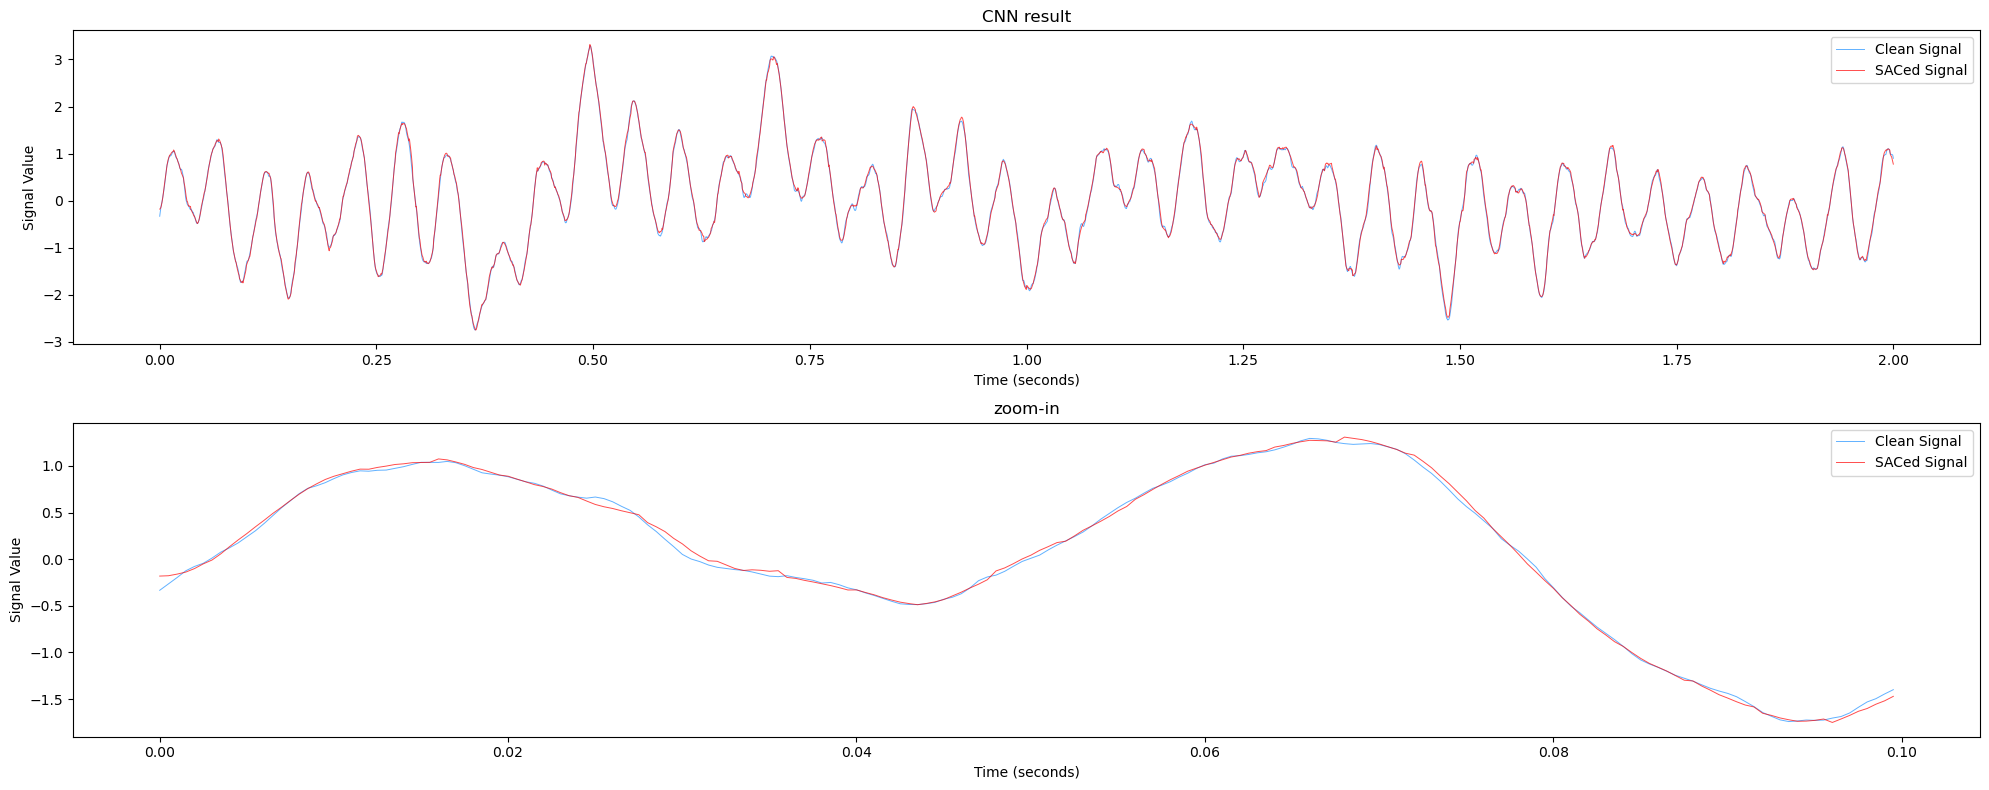

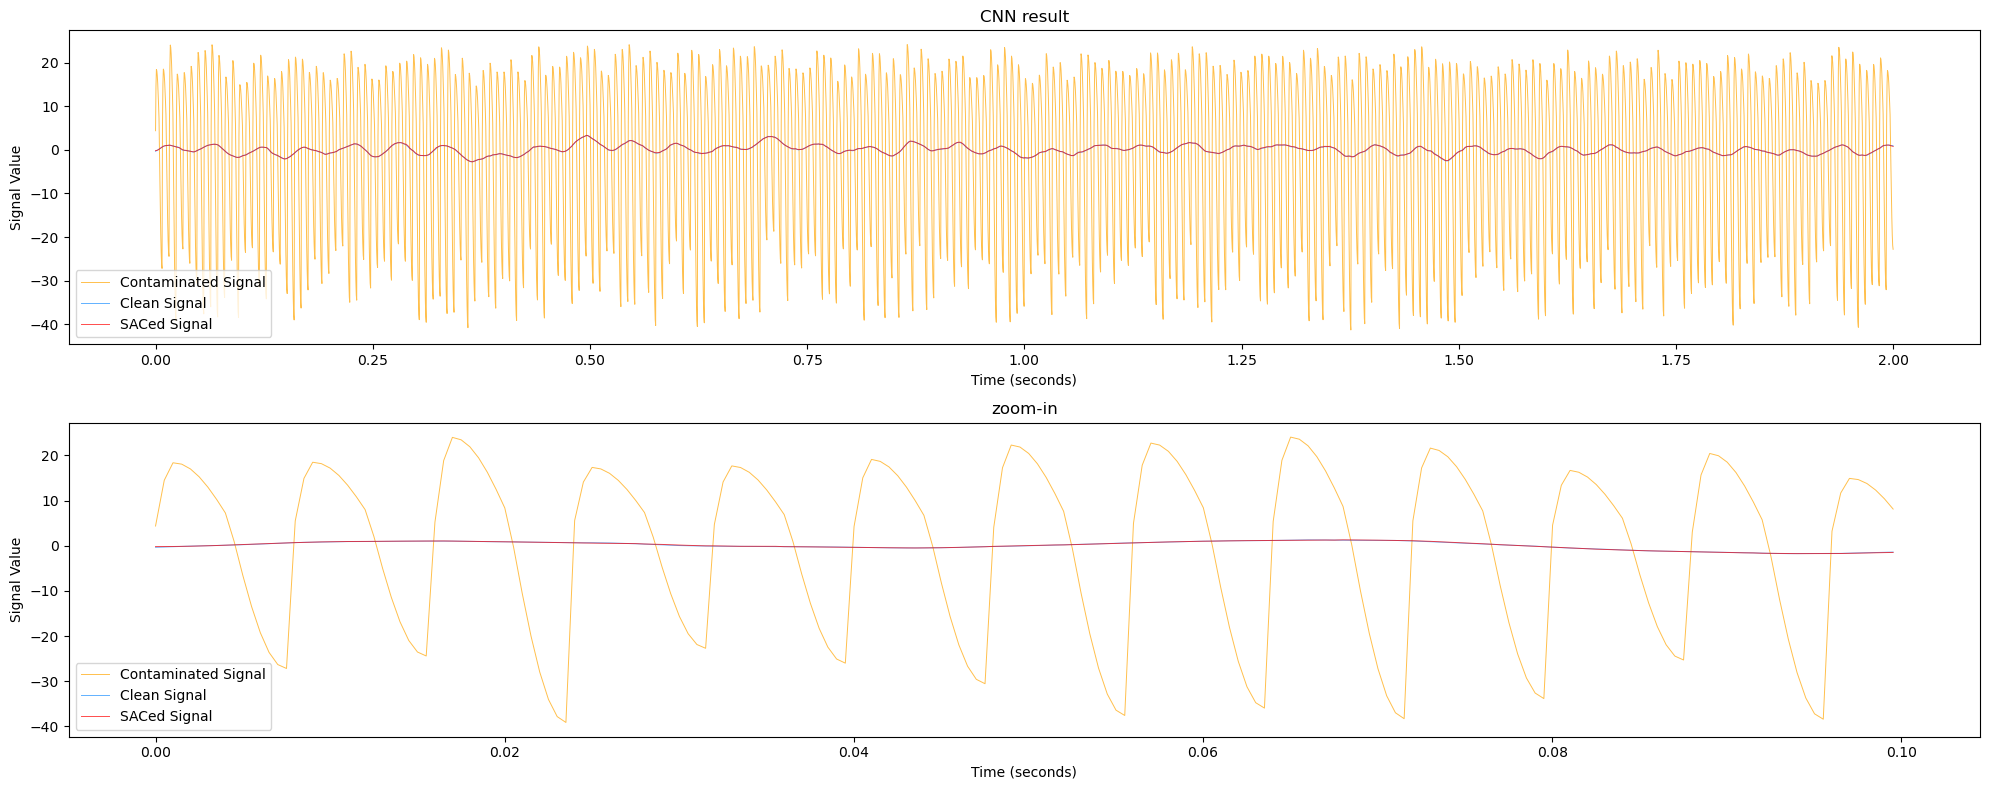

<Frequency Domain Error>
Mean Absolute Error: 0.5248088040468242
Mean Squared Error: 0.5885400295823144


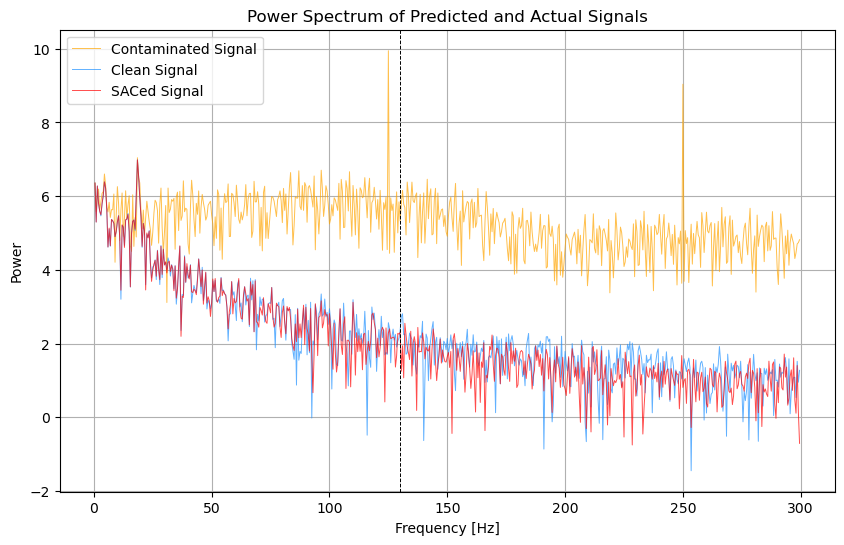

In [17]:
# inverse scaling
Contaminated_inverse_scaled = np.array([scaler_x.inverse_transform(pywt.imra(Contaminated[0]).reshape(-1, 1)).squeeze()])
SACed_inverse_scaled = np.array([scaler_x.inverse_transform(pywt.imra(Contaminated[0]).reshape(-1, 1)).squeeze()])
Clean_inverse_scaled = np.array([scaler_x.inverse_transform(pywt.imra(Contaminated[0]).reshape(-1, 1)).squeeze()])

for x, y_pred, y in zip(Contaminated, SACed, Clean):
    x_inversed = scaler_x.inverse_transform(pywt.imra(x).reshape(-1, 1)).squeeze()
    y_pred_inversed = scaler_y.inverse_transform(pywt.imra(y_pred).reshape(-1, 1)).squeeze()
    y_inversed = scaler_y.inverse_transform(pywt.imra(y).reshape(-1, 1)).squeeze()
    
    Contaminated_inverse_scaled = np.vstack((Contaminated_inverse_scaled, x_inversed))
    SACed_inverse_scaled = np.vstack((SACed_inverse_scaled, y_pred_inversed))
    Clean_inverse_scaled = np.vstack((Clean_inverse_scaled, y_inversed))

Contaminated_inverse_scaled = np.delete(Contaminated_inverse_scaled, 0, axis=0)
SACed_inverse_scaled = np.delete(SACed_inverse_scaled, 0, axis=0)
Clean_inverse_scaled = np.delete(Clean_inverse_scaled, 0, axis=0)

print(Contaminated_inverse_scaled.shape)

# 결과 Plot
Result_Plot(Contaminated_inverse_scaled, SACed_inverse_scaled, Clean_inverse_scaled) # inverse scaled data를 input으로 넣음